<a href="https://colab.research.google.com/github/jalalAzhmatkhan/pattern-recognition/blob/tugas-besar-final/Speech_recognition_Tugas_Besar_23521059.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Speech Recognition - Tugas Besar Mata Kuliah Pattern Recognition**

Nama: Jalaluddin Al Mursyidy Fadhlurrahman<br>
NIM: 23521059
<br><br>
Dokumentasi Tugas Besar ini dapat diakses di:
[Github penulis](https://github.com/jalalAzhmatkhan/pattern-recognition/tree/tugas-besar-final)


**Dataset**<br>
Dataset yang dipakai adalah kumpulan rekaman pengucapan 1 kata dalam bahasa Inggris yang diperoleh dari TensorFlow (Speech Commands dataset). Dataset ini memiliki 105.836 pengucapan dari 2.618 orang yang mengucapkan 35 kata. Kata-kata yang terdaftar pada dataset adalah 'sheila', 'no', 'bed', 'go', 'zero', 'learn', 'cat', 'backward', 'wow', 'forward',
 'yes', 'house', 'dog', 'left', 'eight', 'right', 'three', 'happy', 'nine', 'off',
 'down', 'two', 'up', 'follow', 'stop', 'five', 'bird', 'four', 'visual', 'one',
 'on', 'tree', 'six', 'marvin', dan 'seven'. Tiap label/kata memiliki 2022 data. Setiap pengucapan selama 1 detik disimpan sebagai file berformat WAV dengan sampling rate 16 kHz. <br><br>
 Dataset kemudian dibagi menjadi training set, validation set, dan test set. Pembagian datasetnya adalah dengan rasio 80:10:10 untuk masing-masing training set, validation set, dan test set.

**No 1**<br>
Pada konvolusi temporal yang digunakan oleh Choi et al [1], digunakan TC-ResNet yang merupakan convolutional neural network yang cepat dan akurat untuk kebutuhan keyword spotting (KWS) pada telepon genggam. Pada penelitian ini, digunakan kernel m x 1 (m = 3 untuk layer pertama, dan m = 9 untuk layer lainnya), alih-alih menggunakan kernel 3x3. Semua layer convolution dan layer fully connected tidak memiliki bias, dan setiap batch normalization layer memiliki parameter-parameter yang dapat dilatih untuk scaling dan shifting. Peneliti menggunakan layer Conv-BN-ReLU ketika stride = 1, dan tambahan Conv-BN-ReLU ketika stride = 2. Peneliti menggunakan TC-ResNet8 yang memiliki 3 residual blocks dan {16, 24, 32, 48} channel pada tiap-tiap layer, termasuk convolutional layer pertama sebagai base model.<br><br>

Gouda et al [2] dalam penelitiannya menggunakan Convolutional Neural Network (CNN) untuk Speech Recognition. Model yang digunakan pada section preprocessing mirip dengan model yang bernama "cnn-one-fstride4"[3], akan tetapi filter size yang digunakan adalah 7, stride 3, channels 3, dense 100, dan 63.800 parameter. Deskripsi desain model yang dipakai adalah: convolutional layer dengan non-linearitas, fully connected feed forward layer tanpa non-linearitas, fully connected forward layer dengan non-linearitas, dan softmax output layer.<br><br>

MatchBoxNet, sebuah deep residual network yang terdiri dari block-block 1D time-channel sparable convolution, batch-normalization, ReLU, dan dropout layer, digunakan oleh Majumdar dan Ginsburg [4] untuk Key Word Spotting (KWS) yang didesain khusus untuk device dengan resource komputasi dan memori rendah. Model MatchboxNet 3x2x64 yang digunakan memiliki B = 3 block, dimana setiap block memiliki R = 2 time-channel separable convolutional sub-blocks dengan C = 64 channels, dan tambahan 4  sub-block: prologue - Conv 1, and epilogue - Conv 2, Conv3, Conv4. Block Conv1 memiliki 1 block, 1 sub-block, 128 channel output, dan 11 kernel. Block B1 memiliki 1 block, 2 sub-block, 64 output channel, dan 13 kernel. Block B2 memiliki 1 block, 2 sub-block, 64 output channel, dan 15 kernel. Block B3 memiliki 1 block, 2 sub-block, 64 output channel, dan 17 kernel. Block Conv2 memiliki 1 block, 1 sub-block, 128 output channel, dan 29 kernel (dilation = 2). Block Conv3 memiliki 1 block, 1 sub-block, 128 output channel, dan 1 kernel. Block Conv4 memiliki 1 block, 1 sub-block, output channel sejumlah kelas, dan 1 kernel. Terdapat juga block soft-max dan cross-entrophy.

**No 2**<br><br>
a. Saya menggunakan dataset "Mini Speech Commands" yang merupakan bagian dari "Speech Commands" dataset. Dataset berupa pengucapan selama 1 detik yang disimpan dalam sebuah file WAV dengan sampling rate 16kHz. <br><br>

Pertama-tama, data akan dimuat dari dataset.


In [10]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands = commands[commands != 'speech_commands_v0.02.tar.gz']
commands = commands[commands != '__MACOSX']
commands = commands[commands != 'mini_speech_commands']
print('Command words:', commands)


Command words: ['no' 'go' 'yes' 'left' 'right' 'down' 'up' 'stop']


Kemudian dataset akan dishuffle, dan dilihat jumlahnya.

In [16]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Number of total examples: 8011
Number of examples per label: 1000


Selanjutnya, dataset akan dibagi-bagi ke dalam training set, validation set, dan test set. Rasio yang digunakan adalah 80:10:10, sehingga masing-masing set memiliki data 6400:800:800 data.

In [17]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


Selanjutnya membuat fungsi untuk melakukan pre-processing raw data WAV file, mendapatkan label menggunakan direktori parent dari masing-masing file, dan sebuah fungsi yang menyatukannya.

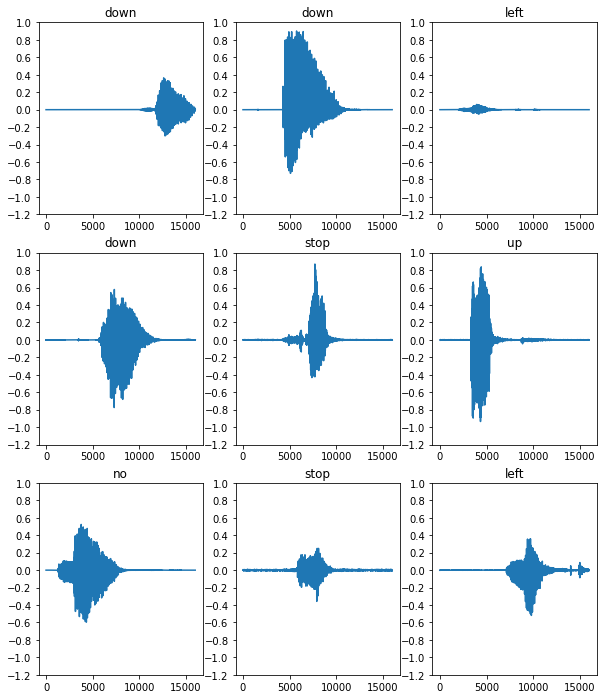

In [19]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


Untuk melakukan ekstraksi fitur, saya menggunakan Short Time Fourier Transform (STFT) untuk mengubah *waveform* menjadi spektrogram.

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


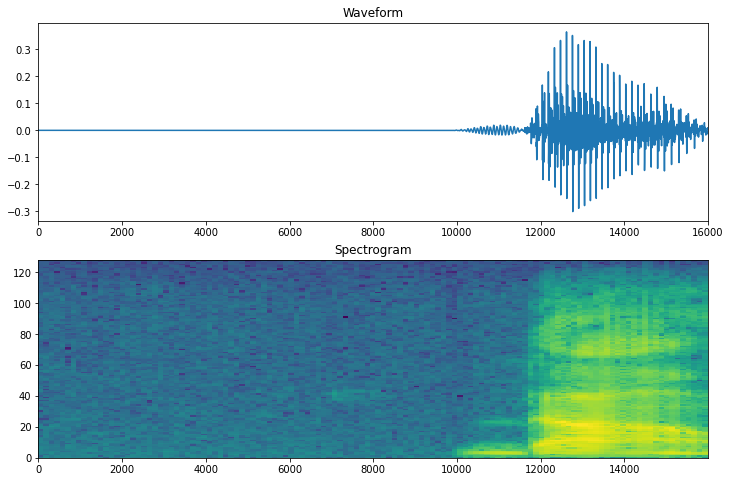

In [20]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
  log_spec = np.log(spectrogram.T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Berikut spektrogram untuk label-label yang ada:

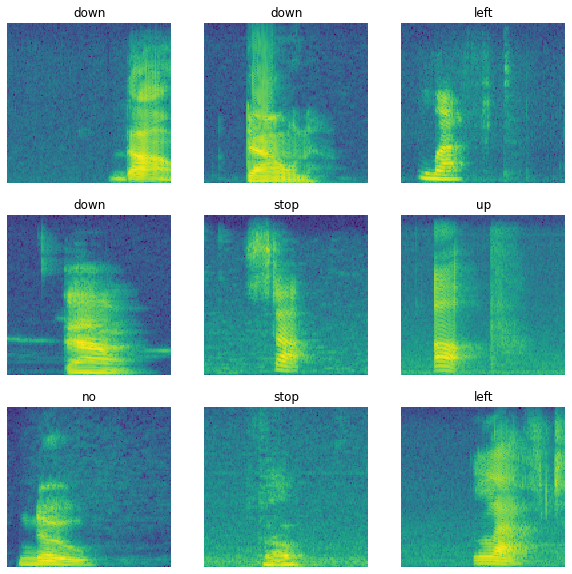

In [21]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()


Selanjutnya melakukan preprocessing pada validation set dan test set.

In [22]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

#Set training & validation set untuk training model
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


Untuk mengurangi read latency ketika training model, maka menggunakan fungsi cache dan prefetch.

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


Untuk pemodelan, saya menggunakan Convolutional Neural Network. Saya melakukan resizing input selain untuk membuat model dapat dilatih lebih cepat, Nichie Aaron dan Mills, Godfrey A. [5] dalam penelitiannya merekomendasikan jumlah neuron sebanyak 20 neuron pada input layer dan 30 neuron pada hidden layer.<br><br>
Arsitektur CNN yang saya gunakan adalah resizing layer, normalization layer, 2 Conv2D layer, dropout layer, flatten layer, dense layer (fully connected layer dengan fungsi activasi ReLU, dropout layer, dan yang terakhir adalah output layer berupa fully connected.

In [30]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(30, 30), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)


InvalidArgumentError: ignored

Selanjutnya saya melakukan compile pada model saya dengan menggunakan optimizer Adam dan cross-entrophy loss.

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


Selanjutnya saya melakukan training model dengan 100 epoch.


In [29]:
EPOCHS = 150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)



Epoch 1/150
 14/100 [===>..........................] - ETA: 33s - loss: 1.8789 - accuracy: 0.2935

InvalidArgumentError: ignored

b. Pada Tugas Besar ini, saya menggunakan dataset "Mini Speech Commands" yang merupakan bagian dari Speech Commands. Dataset ini memiliki 8 kata, yaitu 'no', 'go', 'yes', 'left', 'right', 'down', 'up', dan 'stop'. Masing-masing label memiliki 1000 data. Pembagian dataset adalah dengan rasio 80:10:10, sehingga masing-masing training set, validation set, dan test set adalah 6400:800:800 data.

In [13]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Number of total examples: 8011
Number of examples per label: 1000


In [14]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


**Referensi**


1.   Choi, Seungwoo et al. Temporal Convolution for Real-time Keyword Spotting on Mobile Devices. 2019. arXiv: 1904.03814v2[cs.SD].
2.   Gouda, Sanjay et al. Speech Recognition: Key Word Spotting through Image Recognition. 2020. arXiv: 1803.03759v1 [stat.ML].
3.   Sainath, Tara N. and Parada, Carolina. Convolutional Neural Network for Small-footprint Keyword Spotting. 2015. Google Inc.
4.   Majumdar, Somshubra and Ginsburg, Boris. MatchboxNet: 1D Time-Channel Separable Convolutional Neural Network Architecture for Speech Commands Recognition. 2020. arXiv: 2004.08531v2.

